In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from modules import torch_classes
from torchvision import transforms, utils
from modules.grad_cam import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
net = torch_classes.Net(num_of_classes=33)

#Load trained network weights.
net.load_state_dict(torch.load('CV_file/es_weights/final_weights.pt'))

net.to(device)
net.double()
net.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [3]:
#Train set
labels_path = '../DATA/train_labels.pkl'
data_path = 'train.dat'
data_dims = (8269,10404)
genes_path = 'train.csv'

#Data and labels
train = torch_classes.TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([torch_classes.ToImage(),torch_classes.ToTensor()]))

#Test set
labels_path = '../DATA/test_labels.pkl'
data_path = 'test.dat'
data_dims = (2085,10404)
genes_path = 'test.csv'

test = torch_classes.TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([torch_classes.ToImage(),torch_classes.ToTensor()]))

In [81]:
cancer_names = [['ACC', '79'],
['BLCA', '408'],
['BRCA', '1100'],
['CESC', '306'],
['CHOL', '36'],
['COAD', '478'],
['DLBC', '48'],
['ESCA', '185'],
['GBM', '166'],
['HNSC', '522'],
['KICH', '66'],
['KIRC', '534'],
['KIRP', '291'],
['LAML', '173'],
['LGG', '530'],
['LIHC', '373'],
['LUAD', '517'],
['LUSC', '501'],
['MESO', '87'],
['OV', '307'],
['PAAD', '179'],
['PCPG', '184'],
['PRAD', '498'],
['READ', '167'],
['SARC', '263'],
['SKCM', '472'],
['STAD', '415'],
['TGCT', '156'],
['THCA', '509'],
['THYM', '120'],
['UCEC', '547'],
['UCS', '57'],
['UVM', '80']]

In [6]:
classes = range(0,34)

In [59]:
print("Total in class samples")
print(np.sum(test.labels,axis=0)+np.sum(train.labels,axis=0))
trn_class_nums = np.sum(train.labels,axis=0)
tst_class_nums = np.sum(test.labels,axis=0)

Total in class samples
[  79  408 1100  306   36  478   48  185  166  522   66  534  291  173
  530  373  517  501   87  307  179  184  498  167  263  472  415  156
  509  120  547   57   80]


### Average image over train set

In [56]:
#Method to calculate the average image per class
total_samples = 0
avg_class_imgs = []
for i in range(33):
    img = 0
    #labels = 0
    for trn_i in range(total_samples,total_samples+trn_class_nums[i]):
        img = img + train.get_data(trn_i)['data'].numpy()
        #labels = labels + train.get_data(trn_i)['label'].numpy() #Sanity check
    
    #print(labels)
    avg_class_imgs.append(img/trn_class_nums[i])
    total_samples = total_samples + trn_class_nums[i]

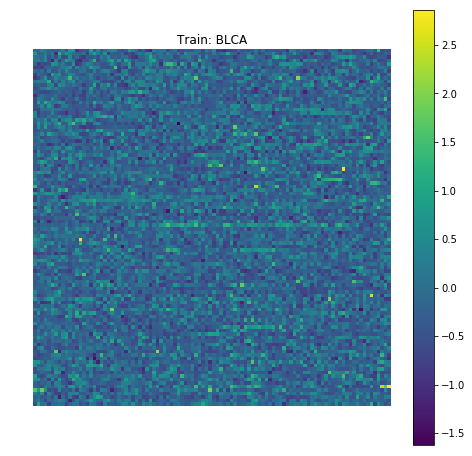

In [134]:
# fig = plt.figure()
# for i, img in enumerate(avg_class_imgs):
#     plt.subplot(11,3,i+1)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.title(cancer_names[i][0])
    
# fig.set_size_inches(20, 80)

j = 1
fig = plt.figure()
plt.imshow(avg_class_imgs[j])
plt.colorbar()
plt.title('Train: '+cancer_names[j][0])
plt.axis('off')
fig.set_size_inches(8,8)

### Average image over test set

In [123]:
import matplotlib as mpl
mpl.rcParams["image.cmap"]

'viridis'

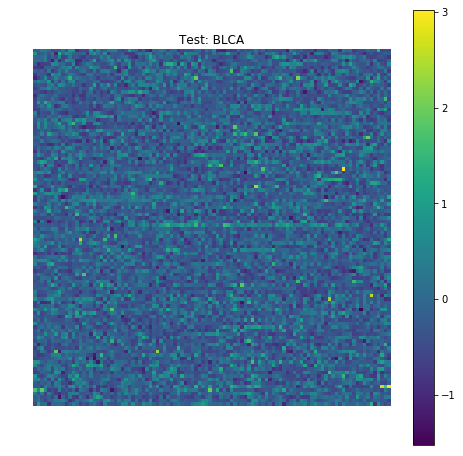

In [131]:
#Method to calculate the average image per class
total_samples = 0
avg_tst_imgs = []
for i in range(33):
    img = 0
    #labels = 0
    for tst_i in range(total_samples,total_samples+tst_class_nums[i]):
        img = img + test.get_data(tst_i)['data'].numpy()
        #labels = labels + test.get_data(tst_i)['label'].numpy() #Sanity check
    
    #print(labels)
    avg_tst_imgs.append(img/tst_class_nums[i])
    total_samples = total_samples + tst_class_nums[i]
    
fig = plt.figure()
plt.imshow(avg_tst_imgs[j])
plt.colorbar()
plt.title('Test: '+cancer_names[j][0])
plt.axis('off')
fig.set_size_inches(8,8)


In [136]:
gcam = GradCAM(model=net)
_ = gcam.forward(image)

In [137]:
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [ ]:
target_layer = 'conv1'

In [ ]:
predictions = bp.forward(image)

In [ ]:
for i in range(1):
    print("[{:.5f}] {}".format(predictions[i][0], classes[predictions[i][1]]))

    # Grad-CAM
    gcam.backward(idx=predictions[i][1])
    region = gcam.generate(target_layer=target_layer)

    save_gradcam(
        "results/-gradcam-{}-{}.png".format(
            target_layer, classes[predictions[i][1]]
        ),
        region,
        raw_image,
    )

In [ ]:
total_samples = 0
for i in range(33):
    for trn_i in range(total_samples,total_samples+trn_class_nums[i]):
        image = train.get_data(trn_i)['data'].unsqueeze(dim=0).unsqueeze(dim=0)
        image = image.to(device)
        predictions = bp.forward(image)
        
    total_samples = total_samples + trn_class_nums[i]

In [7]:
img = train.get_data(3000) #get which sample, only call one at a time

In [8]:
img['label']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
image = img['data'].unsqueeze(dim=0).unsqueeze(dim=0)
image = image.to(device)

In [10]:
bp = BackPropagation(model=net) #Class from grad cam functions

In [59]:
predictions = bp.forward(image)

In [60]:
for i in range(1):
    print("[{:.5f}] {}".format(predictions[i][0], classes[predictions[i][1]]))

    bp.backward(idx=predictions[i][1])
    gradient = bp.generate()

    save_gradient(
        "./results/-vanilla-{}.png".format(classes[predictions[i][1]]),
        gradient,
    )

# Remove all the hook function in the "model"
bp.remove_hook()

[1.00000] 2


In [61]:
regular_img = image.detach().cpu().numpy().squeeze()

In [62]:
raw_image = image.detach().cpu().numpy().squeeze()[:,:,None]

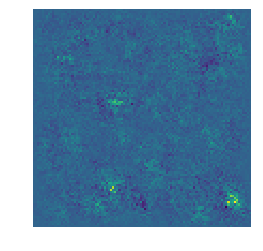

In [63]:
plt.imshow(gradient.squeeze())
plt.axis('off')
plt.savefig('paper_imgs/gradient3.png')

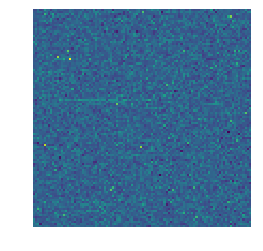

In [64]:
plt.imshow(regular_img)
plt.axis('off')
plt.savefig('paper_imgs/regular3.png')

In [65]:
gcam = GradCAM(model=net)
_ = gcam.forward(image)

gbp = GuidedBackPropagation(model=net)
_ = gbp.forward(image)

In [66]:
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [67]:
target_layer = 'conv1'

In [68]:
for i in range(1):
        print("[{:.5f}] {}".format(predictions[i][0], classes[predictions[i][1]]))

        # Grad-CAM
        gcam.backward(idx=predictions[i][1])
        region = gcam.generate(target_layer=target_layer)

        save_gradcam(
            "results/-gradcam-{}-{}.png".format(
                target_layer, classes[predictions[i][1]]
            ),
            region,
            raw_image,
        )

        # Guided Backpropagation
        gbp.backward(idx=predictions[i][1])
        gradient = gbp.generate()

        # Guided Grad-CAM
        h, w, _ = gradient.shape
        region = cv2.resize(region, (w, h))[..., np.newaxis]
        output = gradient * region

        save_gradient(
            "results/-guided-{}.png".format(classes[predictions[i][1]]),
            gradient,
        )
        save_gradient(
            "results/-guided_gradcam-{}-{}.png".format(
                target_layer, classes[predictions[i][1]]
            ),
            output,
        )

[1.00000] 2


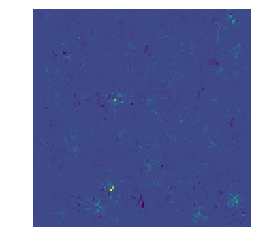

In [69]:
plt.imshow(output.squeeze())
plt.axis('off')
plt.savefig('paper_imgs/gradcam3.png')

In [22]:
activations = output.squeeze()

In [23]:
np.argmax(activations)

2466

In [26]:
np.argsort(activations)

array([[90, 41, 51, ..., 36, 43, 42],
       [75, 74, 28, ..., 40, 44, 43],
       [43, 18, 76, ..., 49, 51, 50],
       ...,
       [81, 51, 41, ..., 87, 60,  5],
       [51, 90, 35, ..., 32, 60, 36],
       [51, 34, 95, ..., 62, 33, 61]])

In [24]:
train.labels[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
train.genes[2466]

'CYP11B1|1584'